In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b
import bayes3d.genjax
import joblib
from tqdm import tqdm
import os
import jax.numpy as jnp
import jax
import numpy as np
import genjax

import trimesh
import matplotlib.pyplot as plt

# console = genjax.pretty(show_locals=False)

In [3]:
from jax import (jit, vmap)
from xsight.utils import *
from xsight.importance import _importance_sampling, _update, _generate, _simulate, _propose
from xsight.pose import pack_pose, unpack_pose, apply_pose, from_euler, CAM_ALONG_X
from xsight.meshes import *
from xsight.plotting import *

In [ ]:
# _scaling = 1.0/1000.0
# _far     = 5.0

# intrinsics = b.Intrinsics(
#     height = 100,
#     width  = 100,
#     fx = 450.0, fy = 450.0,
#     cx = 50.0,  cy = 50.0,
#     near = 0.01, far = _far
# )

In [12]:
OUTLIER_VOLUME = 1000.0
VARIANCE_GRID  = jnp.array([0.0001, 0.001, 0.01])
OUTLIER_GRID   = jnp.array([0.00001, 0.0001, 0.001])


In [9]:
_scaling = 1.0/1000.0
_far     = 5.0

intrinsics = b.Intrinsics(
    height=50,
    width=50,
    fx=250.0, fy=250.0,
    cx=25.0, cy=25.0,
    near = 0.01, far = _far
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=_scaling)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)


In [10]:
from bayes3d.genjax.genjax_distributions import *
from xsight.likelihood_b import make_blurred_sensor_model, make_blurred_sensor_model_2

def make_constrain_adder(sensor_model_type):

    def add_constraints(X, ch=None):
        assert X.shape[-1] == 3 or X.shape[-1] == 4
        
        D  = jnp.linalg.norm(X[...,:3].reshape(-1,3), axis=-1)
        D = jnp.clip(D, 0.0, _far)
        
        if ch is None: ch = genjax.choice_map({})

        match sensor_model_type:
            case "blurred" : 
                ch["image"] = genjax.choice_map({"X": genjax.vector_choice_map({"measurement": D})})
            case "blurred2" : 
                ch["image"] = genjax.choice_map({"X": genjax.vector_choice_map({"measurement": D})})
            case "baseline": 
                ch["image"] = X[...,:3]
        
        return ch

    return add_constraints



def make_model(sensor_model_type):

    @genjax.gen
    def model_0(array, possible_object_indices, pose_bounds, contact_bounds, all_box_dims, outlier_volume, focal_length):
        
        indices        = jnp.array([], dtype=jnp.int32)
        root_poses     = jnp.zeros((0,4,4))
        contact_params = jnp.zeros((0,3))
        faces_parents  = jnp.array([], dtype=jnp.int32)
        faces_child    = jnp.array([], dtype=jnp.int32)
        parents        = jnp.array([], dtype=jnp.int32)

        for i in range(array.shape[0]):

            index = uniform_discrete(possible_object_indices) @ f"id_{i}"

            pose = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"root_pose_{i}"

            params = contact_params_uniform(contact_bounds[0], contact_bounds[1]) @ f"contact_params_{i}"

            parent_obj = uniform_discrete(jnp.arange(-1,array.shape[0] - 1)) @ f"parent_{i}"
            parent_face = uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
            child_face = uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"

            indices = jnp.concatenate([indices, jnp.array([index])])
            root_poses = jnp.concatenate([root_poses, pose.reshape(1,4,4)])
            contact_params = jnp.concatenate([contact_params, params.reshape(1,-1)])
            parents = jnp.concatenate([parents, jnp.array([parent_obj])])
            faces_parents = jnp.concatenate([faces_parents, jnp.array([parent_face])])
            faces_child = jnp.concatenate([faces_child, jnp.array([child_face])])
        
        box_dims = all_box_dims[indices]
        poses = b.scene_graph.poses_from_scene_graph(
            root_poses, box_dims, parents, contact_params, faces_parents, faces_child)

        camera_pose = uniform_pose(
            pose_bounds[0], 
            pose_bounds[1], 
        ) @ f"camera_pose"

        rendered = b.RENDERER.render(
            jnp.linalg.inv(camera_pose) @ poses , indices
        )[...,:3]

        variance = genjax.distributions.tfp_uniform(0.00000000001, 10000.0) @ "variance"
        outlier_prob  = genjax.distributions.tfp_uniform(-0.01, 10000.0) @ "outlier_prob"
        image = image_likelihood(rendered, variance, outlier_prob, outlier_volume, focal_length)  @ "image"

        return rendered, indices, poses, parents, contact_params, faces_parents, faces_child, root_poses, image


    img_likelihood = make_blurred_sensor_model(_far, 3)

    @genjax.gen
    def model_1(array, possible_object_indices, pose_bounds, contact_bounds, all_box_dims, outlier_volume, focal_length):
        
        indices        = jnp.array([], dtype=jnp.int32)
        root_poses     = jnp.zeros((0,4,4))
        contact_params = jnp.zeros((0,3))
        faces_parents  = jnp.array([], dtype=jnp.int32)
        faces_child    = jnp.array([], dtype=jnp.int32)
        parents        = jnp.array([], dtype=jnp.int32)

        for i in range(array.shape[0]):

            index = uniform_discrete(possible_object_indices) @ f"id_{i}"

            pose = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"root_pose_{i}"

            params = contact_params_uniform(contact_bounds[0], contact_bounds[1]) @ f"contact_params_{i}"

            parent_obj = uniform_discrete(jnp.arange(-1,array.shape[0] - 1)) @ f"parent_{i}"
            parent_face = uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
            child_face = uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"

            indices = jnp.concatenate([indices, jnp.array([index])])
            root_poses = jnp.concatenate([root_poses, pose.reshape(1,4,4)])
            contact_params = jnp.concatenate([contact_params, params.reshape(1,-1)])
            parents = jnp.concatenate([parents, jnp.array([parent_obj])])
            faces_parents = jnp.concatenate([faces_parents, jnp.array([parent_face])])
            faces_child = jnp.concatenate([faces_child, jnp.array([child_face])])
        
        box_dims = all_box_dims[indices]
        poses = b.scene_graph.poses_from_scene_graph(
            root_poses, box_dims, parents, contact_params, faces_parents, faces_child)

        camera_pose = uniform_pose(
            pose_bounds[0], 
            pose_bounds[1], 
        ) @ f"camera_pose"

        rendered = b.RENDERER.render(
            jnp.linalg.inv(camera_pose) @ poses , indices
        )[...,:3]

        variance = genjax.distributions.tfp_uniform(0.00000000001, 10000.0) @ "variance"
        outlier_prob  = genjax.distributions.tfp_uniform(-0.01, 10000.0) @ "outlier_prob"
        # image = image_likelihood(rendered, variance, outlier_prob, outlier_volume, focal_length) 
        image = img_likelihood(rendered, jnp.sqrt(variance), outlier_prob) @ "image"

        return rendered, indices, poses, parents, contact_params, faces_parents, faces_child, root_poses, image

    img_likelihood2 = make_blurred_sensor_model_2(_far, 3)

    @genjax.gen
    def model_2(array, possible_object_indices, pose_bounds, contact_bounds, all_box_dims, outlier_volume, focal_length):
        
        indices        = jnp.array([], dtype=jnp.int32)
        root_poses     = jnp.zeros((0,4,4))
        contact_params = jnp.zeros((0,3))
        faces_parents  = jnp.array([], dtype=jnp.int32)
        faces_child    = jnp.array([], dtype=jnp.int32)
        parents        = jnp.array([], dtype=jnp.int32)

        for i in range(array.shape[0]):

            index = uniform_discrete(possible_object_indices) @ f"id_{i}"

            pose = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"root_pose_{i}"

            params = contact_params_uniform(contact_bounds[0], contact_bounds[1]) @ f"contact_params_{i}"

            parent_obj = uniform_discrete(jnp.arange(-1,array.shape[0] - 1)) @ f"parent_{i}"
            parent_face = uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
            child_face = uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"

            indices = jnp.concatenate([indices, jnp.array([index])])
            root_poses = jnp.concatenate([root_poses, pose.reshape(1,4,4)])
            contact_params = jnp.concatenate([contact_params, params.reshape(1,-1)])
            parents = jnp.concatenate([parents, jnp.array([parent_obj])])
            faces_parents = jnp.concatenate([faces_parents, jnp.array([parent_face])])
            faces_child = jnp.concatenate([faces_child, jnp.array([child_face])])
        
        box_dims = all_box_dims[indices]
        poses = b.scene_graph.poses_from_scene_graph(
            root_poses, box_dims, parents, contact_params, faces_parents, faces_child)

        camera_pose = uniform_pose(
            pose_bounds[0], 
            pose_bounds[1], 
        ) @ f"camera_pose"

        rendered = b.RENDERER.render(
            jnp.linalg.inv(camera_pose) @ poses , indices
        )[...,:3]

        variance = genjax.distributions.tfp_uniform(0.00000000001, 10000.0) @ "variance"
        outlier_prob  = genjax.distributions.tfp_uniform(-0.01, 10000.0) @ "outlier_prob"
        image = img_likelihood2(rendered, jnp.sqrt(variance), outlier_prob) @ "image"

        return rendered, indices, poses, parents, contact_params, faces_parents, faces_child, root_poses, image


    match sensor_model_type:
        case "baseline": return model_0
        case "blurred" : return model_1 
        case "blurred2" : return model_2


get_rendered_image = lambda trace: trace.get_retval()[0]
get_observed_image = lambda trace: trace.get_retval()[8]
get_indices = lambda trace: trace.get_retval()[1]
get_poses = lambda trace: trace.get_retval()[2]
get_parents = lambda trace: trace.get_retval()[3]
get_contact_params = lambda trace: trace.get_retval()[4]
get_faces_parents = lambda trace: trace.get_retval()[5]
get_faces_child = lambda trace: trace.get_retval()[6]
get_root_poses = lambda trace: trace.get_retval()[7]

get_outlier_volume = lambda trace: trace.get_args()[5]
get_focal_length = lambda trace: trace.get_args()[6]
get_far_plane = lambda trace: trace.get_args()[7]

In [13]:
sensor_model_type = ["baseline","blurred","blurred2"][0]
model = make_model(sensor_model_type)
add_constraints = make_constrain_adder(sensor_model_type)

In [14]:
importance_jit = jax.jit(model.importance)

contact_enumerators = [b.make_enumerator([f"contact_params_{i}", "variance", "outlier_prob"]) for i in range(5)]

def add_object(trace, key, obj_id, parent, face_parent, face_child):
    N = b.get_indices(trace).shape[0] + 1
    choices = trace.get_choices()
    choices[f"parent_{N-1}"] = parent
    choices[f"id_{N-1}"] = obj_id
    choices[f"face_parent_{N-1}"] = face_parent
    choices[f"face_child_{N-1}"] = face_child
    choices[f"contact_params_{N-1}"] = jnp.zeros(3)
    return model.importance(key, choices,
        (jnp.arange(N), *trace.get_args()[1:])
    )[1]

add_object_jit = jax.jit(add_object)

def c2f_contact_update(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number][3](trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number][0](
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    )

    
c2f_contact_update_jit = jax.jit(c2f_contact_update, static_argnames=("number",))

In [15]:
OUTLIER_VOLUME = 1000.0
VARIANCE_GRID = jnp.array([0.0001, 0.001, 0.01])
OUTLIER_GRID = jnp.array([0.00001, 0.0001, 0.001])

grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), (0.02, jnp.pi, (5,5,51)), (0.01, jnp.pi/5, (11,11,11)), (0.01, 0.0, (21,21,1)),(0.05, 0.0, (21,21,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]


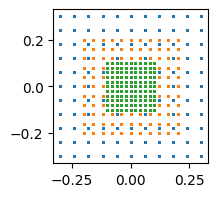

In [16]:
plt.figure(figsize=(2,2))
plt.scatter(*contact_param_gridding_schedule[0][:,:2].T, s=1);
plt.scatter(*contact_param_gridding_schedule[1][:,:2].T, s=1);
plt.scatter(*contact_param_gridding_schedule[2][:,:2].T, s=1);

In [17]:
V_VARIANT = 0
O_VARIANT = 0
HIERARCHICAL_BAYES = True

if HIERARCHICAL_BAYES:
    V_GRID = VARIANCE_GRID
    O_GRID = OUTLIER_GRID
else:
    V_GRID, O_GRID = jnp.array([VARIANCE_GRID[V_VARIANT]]), jnp.array([OUTLIER_GRID[O_VARIANT]])

print(V_GRID, O_GRID)

[1.e-04 1.e-03 1.e-02] [1.e-05 1.e-04 1.e-03]


In [18]:
inv = jnp.linalg.inv

59842.16
2.1560652 5.0


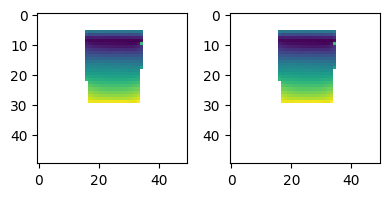

In [30]:
key = keysplit(key)

table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

w0, tr0 = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "parent_3": 0,
    "id_0": jnp.int32(21),
    "id_1": jnp.int32(1),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "contact_params_1": jnp.array([0.,0.05,0.]),
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_parent_3": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "face_child_3": 3,
    "variance": 0.00001**2,
    "outlier_prob": 0.0,
}), (
    jnp.arange(2),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, OUTLIER_VOLUME, 1.0)
)
print(tr0.get_score())
print(jnp.min(get_observed_image(tr0)[...,2]), jnp.max(get_observed_image(tr0)[...,2]))

# _, tr1 = importance_jit(key, tr0.get_choices(), (jnp.arange(1), jnp.arange(22), *tr0.get_args()[2:]))


def prep_image(im, far=_far, eps=0.0):
    im_ = jnp.where(im <far - eps, im, jnp.inf)
    return im_




# =======================
fig, axs = plt.subplots(1,2,figsize=(4,2))
axs[0].imshow(prep_image(get_observed_image(tr0)[...,2], eps=0.1), cmap="viridis")
axs[1].imshow(prep_image(get_rendered_image(tr0)[...,2]), cmap="viridis")
fig.tight_layout()

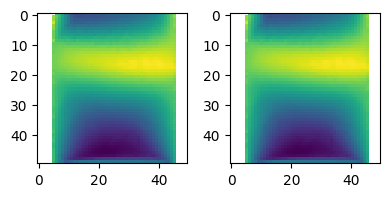

In [126]:
# key = keysplit(key)
# w0, tr0 = importance_jit(key, genjax.choice_map({
#     "parent_0": -1,
#     "parent_1": 0,
#     "id_0": jnp.int32(21),
#     "id_1": jnp.int32(1),
#     "camera_pose": pack_pose(jnp.array([0.0, -0.1,0.0]), jnp.eye(3)),
#     "root_pose_0": table_pose,
#     "contact_params_1": jnp.array([0.,0.,0.]),
#     "face_parent_1": 2,
#     "face_child_1": 3,
#     "variance": 0.0001,
#     "outlier_prob": 0.0001,
# }), (
#     jnp.arange(2),
#     jnp.arange(22),
#     jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
#     jnp.array([jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])]),
#     b.RENDERER.model_box_dims, OUTLIER_VOLUME, 1.0)
# )

# def prep_image(im, far=20.0):
#     im_ = jnp.where(im < 20.0, im, jnp.inf)
#     return im_

# tr = tr0


# # =======================
# fig, axs = plt.subplots(1,2,figsize=(4,2))
# axs[0].imshow(prep_image(tr["image"][...,2]), cmap="viridis")
# axs[1].imshow(prep_image(b.get_rendered_image(tr)[...,2]), cmap="viridis")
# fig.tight_layout()

In [45]:
def _add_object(trace, key, obj_id, parent, face_parent, face_child):

    N = b.get_indices(trace).shape[0] + 1
    choices = trace.get_choices()
    choices[f"parent_{N-1}"] = parent
    choices[f"id_{N-1}"] = obj_id
    choices[f"face_parent_{N-1}"] = face_parent
    choices[f"face_child_{N-1}"] = face_child
    return b.model.importance(key, choices,
        (jnp.arange(N), *trace.get_args()[1:])
    )[1]

_add_obj = lambda tr, key, id: _add_object(tr, key, id, 0, 2, 3)
add_obj  = jit(_add_obj)

obj_prior = jit(vmap(_add_obj, (None, 0, None)))

In [72]:
import jax.tree_util as jtu

def pytree_len(tree):
    all_lengths = jtu.tree_leaves(jtu.tree_map(lambda v: len(v), tree))
    uniqued = set(all_lengths)
    assert len(uniqued) == 1
    return uniqued.pop()

1000


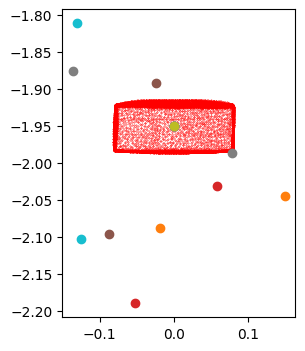

In [81]:
N = 1_000
key, keys = keysplit(key, 1, 1_000)
trs = obj_prior(tr0, keys, 13)

N = pytree_len(trs)
print(N)
# tr = trs.slice(1)
# ps = get_poses(tr) 


# # =======================
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.set_aspect(1)

ps = get_poses(tr0)
x,r = unpack_pose(ps[1])
xs  = meshes[tr[f"id_{1}"]].vertices@r.T + x
xs  = xs@table_pose[:3,:3].T
ax.scatter(*xs[:,[0,1]].T, s=0.1, c="r", zorder=1)

for i in range(10):
    tr = trs.slice(i)
    ps = get_poses(tr) 
    for i in range(1,3):
        x,r = unpack_pose(ps[i])
        y = table_pose[:3,:3]@x
        ax.scatter(y[0],y[1], zorder=3)
        # xs  = meshes[tr[f"id_{i}"]].vertices@r.T + x
        # xs  = xs@table_pose[:3,:3].T
        # if i==2: ax.scatter(*xs[:,[0,1]].T, s=0.1, c="b", alpha=0.01, zorder=1)

In [43]:
def addr(i): return [f"id_{i}", f"root_pose_{i}", f"contact_params_{i}", f"parent_{i}", f"face_parent_{i}", f"face_child_{i}"]

def _reject(tr0, tr1, eps=1e-2):
    N0 = b.get_indices(tr0).shape[0]
    N1 = b.get_indices(tr1).shape[0]
    thresh = tr0.score + tr0.project(genjax.select(*addr(1))) - N1*jnp.log(1/N0) + N1*jnp.log(1/N1)
    return jnp.abs(tr1.score - thresh) < eps

accept = vmap(_reject, (None, 0))

@jit
def posterior(keys, tr0, obj_id=13):
    trs = obj_prior(tr0, keys, obj_id)
    acc = accept(tr0, trs)
    return trs, acc

In [44]:
key, keys = keysplit(key, 1, 10_000)
trs, acc = posterior(keys, tr0)
print(acc.sum())

%timeit -n 1 -r 1 posterior(keys, tr0);

0
68.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [38]:
def take_a_pic(tr, p, channel=2):
    key = jax.random.PRNGKey(0)
    ch = tr.strip()
    ch["camera_pose"] = p

    _, tr_ = importance_jit(key, ch, tr.args)
    return b.get_rendered_image(tr_)[...,channel]

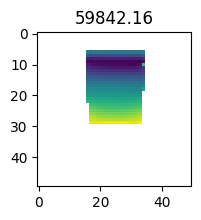

In [39]:
tr = tr0
im = prep_image(b.get_rendered_image(tr)[...,2])
plt.figure(figsize=(2,2))
plt.title(tr.score)
plt.imshow(im)
plt.show()

In [41]:
p = b.t3d.transform_from_pos_target_up(
        table_pose[:3,3].at[1].add(-2.),
        table_pose[:3,3],
        jnp.array([jnp.cos(0.5*jnp.pi), 0.0, jnp.sin(0.5*jnp.pi)]),
    )

trs_ = trs.slice(acc)
sc_  = trs_.get_score

# tr = trs_.slice(0)
# im = take_a_pic(tr, p)

# for i in range(1, 3):
#     tr = trs_.slice(i)
#     im_ = take_a_pic(tr, p)
#     im = jnp.where(im < im_, im, im_)

# plt.imshow(prep_image(im))

3


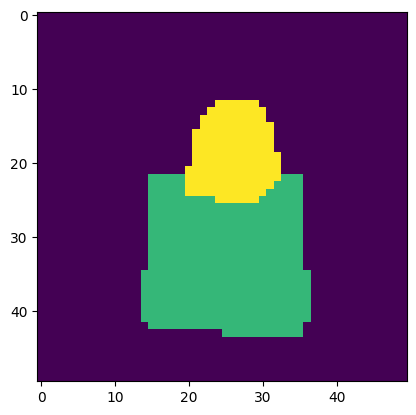

In [30]:
print(b.get_indices(tr).shape[0])
plt.imshow( take_a_pic(tr, p, channel=3), vmin=0, vmax=3)